In [1]:
import os
from src import *
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np

other = {Tester.OPT_ALL_RACE_SPLITS: True}
other_fb = other.copy()
other_fb[BaseModel.OPT_FBALANCE] = True
all_metrics = Metrics.get_all_names()

datasets =  [Tester.COMPAS_D, Tester.ADULT_D]
mls = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       None,    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, None,    other)
}


## ALL METRICS TABLE

In [2]:
# 1 file each for compas and adult tables. 
# func input: dataset, reps, metrics?, filename

def all_race_splits(dataset, reps, filename, metrics = all_metrics, clear_file = True):
    file = os.path.join("results",filename +".csv")
    if clear_file: os.remove(file)
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls.values()):
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth)

In [14]:
# call both
repetitions = 1
all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING")
all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING")


 new tester ---------------------------------
--------------
Caucasian  pos: 894  neg: 543
race: Caucasian  pos: 371  neg: 156
race: Other  pos: 53  neg: 19
race: Hispanic  pos: 93  neg: 30
race: African-American  pos: 364  neg: 333
--------------
Caucasian  pos: 748  neg: 689
race: Caucasian  pos: 278  neg: 249
race: Other  pos: 49  neg: 23
race: Hispanic  pos: 89  neg: 34
race: African-American  pos: 319  neg: 378
--------------
Caucasian  pos: 872  neg: 565
race: Caucasian  pos: 348  neg: 148
race: Other  pos: 74  neg: 19
race: Hispanic  pos: 89  neg: 37
race: African-American  pos: 356  neg: 357
--------------
Caucasian  pos: 864  neg: 573
race: Caucasian  pos: 347  neg: 149
race: Other  pos: 75  neg: 18
race: Hispanic  pos: 87  neg: 39
race: African-American  pos: 350  neg: 363

 new tester ---------------------------------
--------------
White  pos: 1298  neg: 5215
race: White  pos: 1197  neg: 4402
race: Asian-Pac-Islander  pos: 52  neg: 159
race: Black  pos: 43  neg: 544
race: 

## GRAPHS 

In [4]:
# func to generate the graph
# input deault values arr, each bias mit arrs, x axis labels? , 
def make_graph(plt,baselines: List[float], results: Dict[str,List[float]], labels: List[str]):
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, baselines, align='center', alpha=0.5, label = "baseline")
    #plt.xticks(y_pos, labels)
    plt.set(xticks=y_pos, xticklabels=labels)

    for k, v in results.items():
        plt.plot(v, linestyle='--', marker='o', label="bias mit towards "+k)

    plt.legend()
    return plt


In [5]:
# func for running the experiment and returning graph
# input: Dataset, Default ML, Bias Mit ML, metric, title, reps
def graph_all_race_splits(plt,dataset, baseline, mitigation, metric, title, reps):
    tester = Tester(os.path.join("results","history" +".csv"))
    
    bias_mit, method, method2, pre, oth = baseline
    tester.run_test(all_metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth)
    baseline_results = tester.get_eval_for_each_race_split(metric)
    races = list(baseline_results.keys())

    #results = {key:list(baseline_results.values()) for key in races}
    results = {key:[] for key in races}
    bias_mit, method, method2, pre, oth = mitigation
    for race in races:
        tester.update_training_race_split(race)
        tester.run_test(all_metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth)
        results[race] = list(tester.get_eval_for_each_race_split(metric).values())

    make_graph(plt,list(baseline_results.values()), results, races)

    plt.set_ylabel(metric)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt


In [6]:
def run_experiment_group(reps, metric):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(21, 7, forward=True)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric, "FairMask effect on COMPAS", reps)
    graph_all_race_splits(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on COMPAS", reps)
    graph_all_race_splits(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric, "FairMask effect on Adult", reps)
    graph_all_race_splits(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on Adult", reps)

    plt.show()

"""
COMPAS:
Caucasian  count: 2454
Other  count: 377
Hispanic  count: 637
African-American  count: 3696

ADULT:
Amer-Indian-Eskimo  count: 311
White  count: 27816
Asian-Pac-Islander  count: 1039
Black  count: 3124
Other  count: 271
""" 


'\nCOMPAS:\nCaucasian  count: 2454\nOther  count: 377\nHispanic  count: 637\nAfrican-American  count: 3696\n\nADULT:\nAmer-Indian-Eskimo  count: 311\nWhite  count: 27816\nAsian-Pac-Islander  count: 1039\nBlack  count: 3124\nOther  count: 271\n'


 new tester ---------------------------------
--------------
Caucasian  pos: 866  neg: 571
race: Caucasian  pos: 341  neg: 155
race: Other  pos: 59  neg: 13
race: Hispanic  pos: 95  neg: 32
race: African-American  pos: 364  neg: 368
--------------
Caucasian  pos: 848  neg: 589
race: Caucasian  pos: 328  neg: 168
race: Other  pos: 61  neg: 11
race: Hispanic  pos: 96  neg: 31
race: African-American  pos: 356  neg: 376
--------------
Other  pos: 892  neg: 545
race: Caucasian  pos: 348  neg: 148
race: Other  pos: 58  neg: 14
race: Hispanic  pos: 102  neg: 25
race: African-American  pos: 377  neg: 355
--------------
Hispanic  pos: 865  neg: 572
race: Caucasian  pos: 339  neg: 157
race: Other  pos: 54  neg: 18
race: Hispanic  pos: 102  neg: 25
race: African-American  pos: 363  neg: 369
--------------
African-American  pos: 820  neg: 617
race: Caucasian  pos: 331  neg: 165
race: Other  pos: 53  neg: 19
race: Hispanic  pos: 94  neg: 33
race: African-American  pos: 335  neg: 397

 new tester -

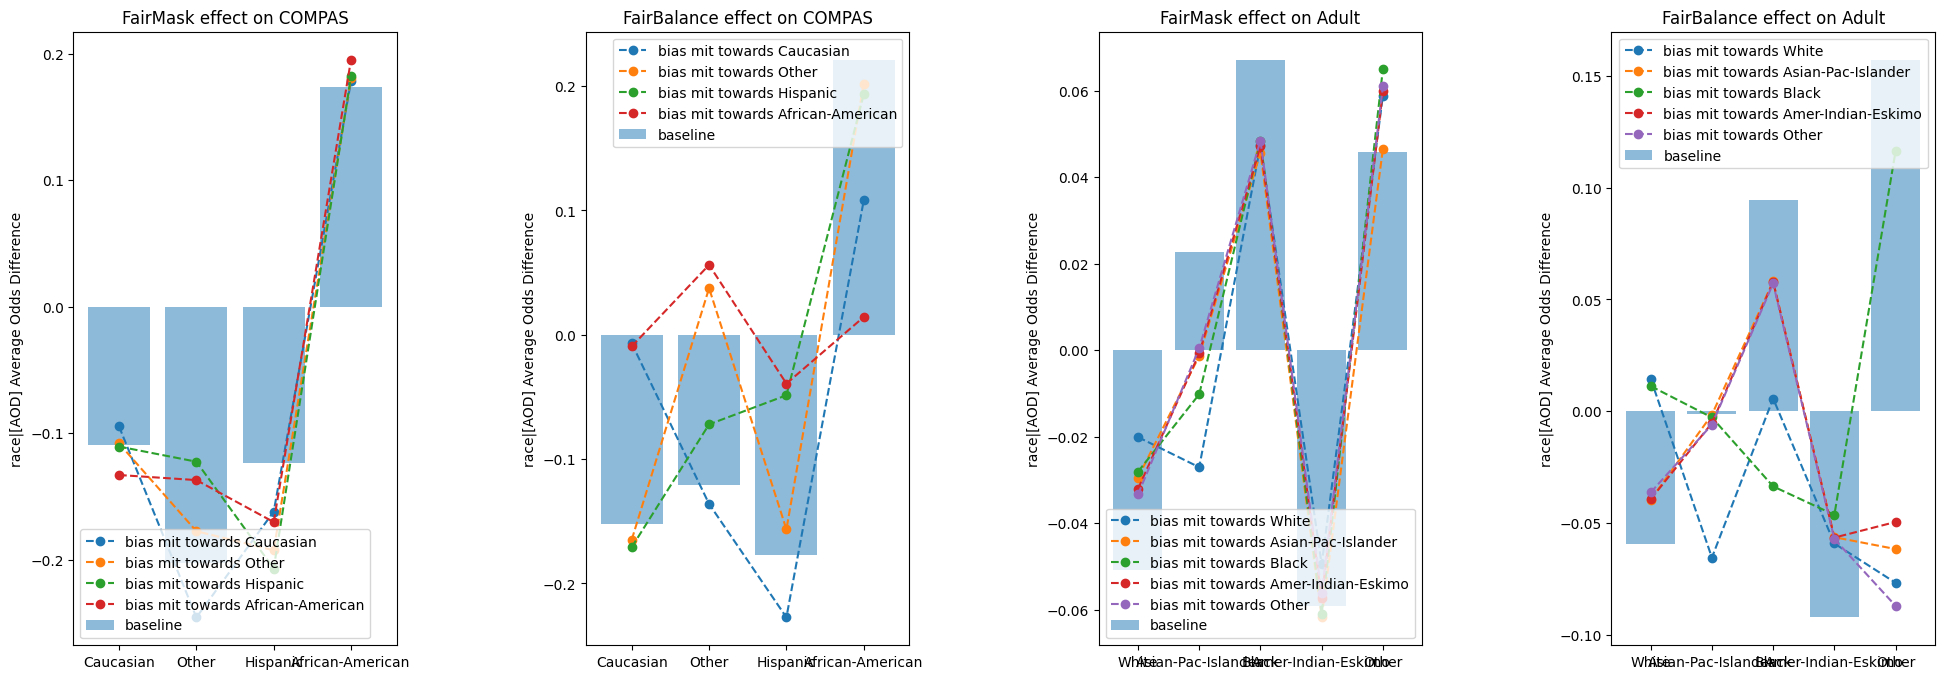

In [7]:
reps = 1
metric =  'race|'+Metrics.AOD
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
Caucasian  pos: 859  neg: 578
race: Caucasian  pos: 330  neg: 151
race: Other  pos: 58  neg: 17
race: Hispanic  pos: 69  neg: 46
race: African-American  pos: 393  neg: 362
--------------
Caucasian  pos: 807  neg: 630
race: Caucasian  pos: 321  neg: 160
race: Other  pos: 58  neg: 17
race: Hispanic  pos: 69  neg: 46
race: African-American  pos: 353  neg: 402
--------------
Other  pos: 842  neg: 595
race: Caucasian  pos: 333  neg: 148
race: Other  pos: 56  neg: 19
race: Hispanic  pos: 76  neg: 39
race: African-American  pos: 370  neg: 385
--------------
Hispanic  pos: 835  neg: 602
race: Caucasian  pos: 325  neg: 156
race: Other  pos: 55  neg: 20
race: Hispanic  pos: 72  neg: 43
race: African-American  pos: 375  neg: 380
--------------
African-American  pos: 804  neg: 633
race: Caucasian  pos: 319  neg: 162
race: Other  pos: 56  neg: 19
race: Hispanic  pos: 75  neg: 40
race: African-American  pos: 347  neg: 408

 new tester ---

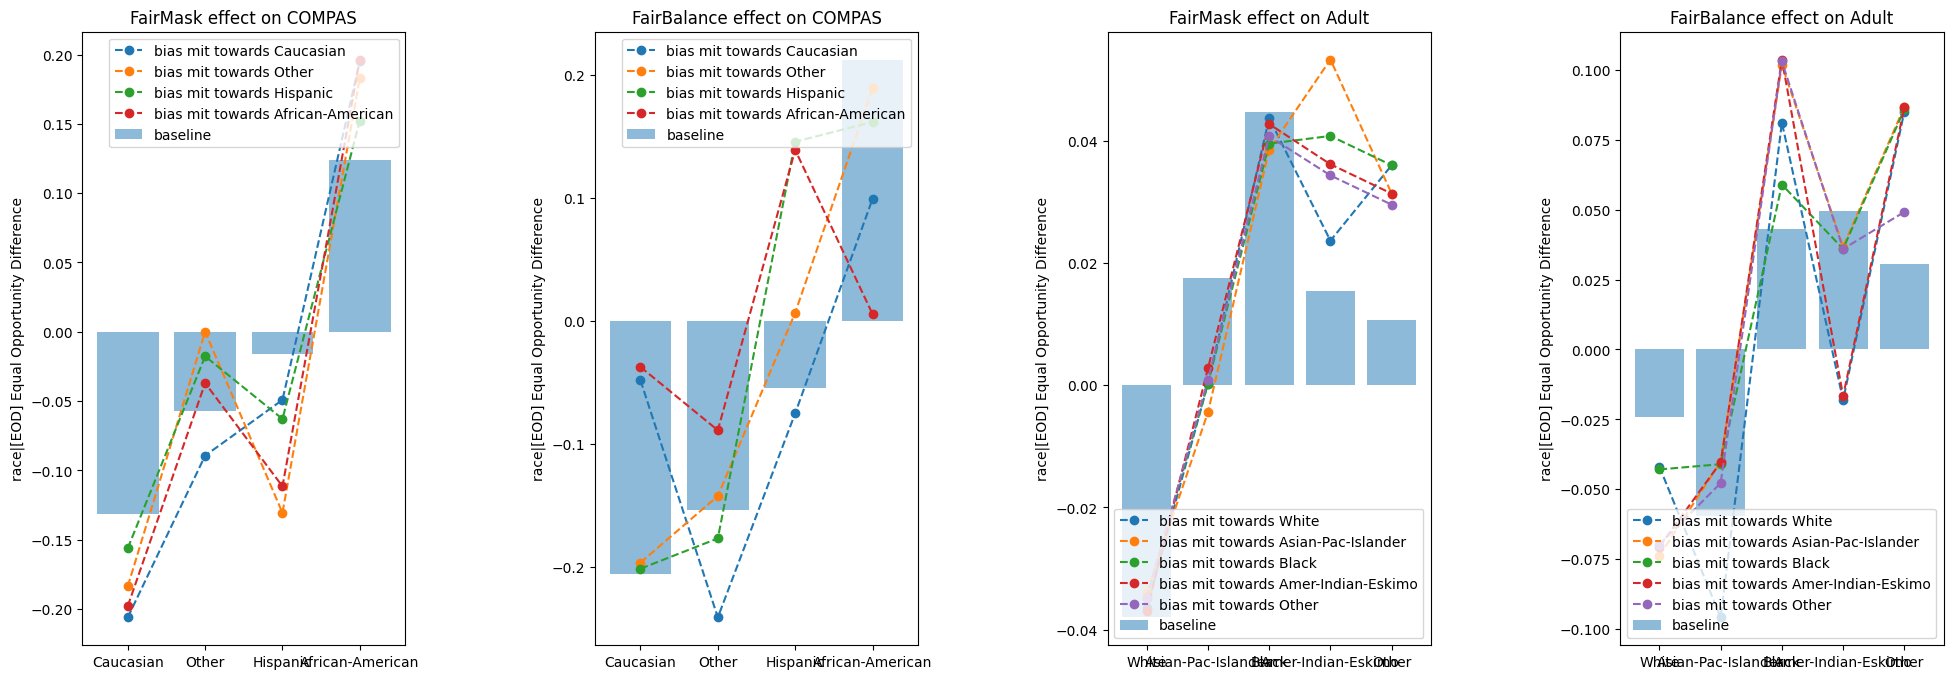

In [8]:
reps = 1
metric =  'race|'+Metrics.EOD
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
Caucasian  pos: 866  neg: 571
race: Caucasian  pos: 327  neg: 151
race: Other  pos: 58  neg: 23
race: Hispanic  pos: 102  neg: 38
race: African-American  pos: 369  neg: 358
--------------
Caucasian  pos: 839  neg: 598
race: Caucasian  pos: 314  neg: 164
race: Other  pos: 60  neg: 21
race: Hispanic  pos: 96  neg: 44
race: African-American  pos: 359  neg: 368
--------------
Other  pos: 908  neg: 529
race: Caucasian  pos: 338  neg: 140
race: Other  pos: 64  neg: 17
race: Hispanic  pos: 101  neg: 39
race: African-American  pos: 395  neg: 332
--------------
Hispanic  pos: 890  neg: 547
race: Caucasian  pos: 332  neg: 146
race: Other  pos: 62  neg: 19
race: Hispanic  pos: 102  neg: 38
race: African-American  pos: 384  neg: 343
--------------
African-American  pos: 856  neg: 581
race: Caucasian  pos: 319  neg: 159
race: Other  pos: 59  neg: 22
race: Hispanic  pos: 97  neg: 43
race: African-American  pos: 371  neg: 356

 new tester 

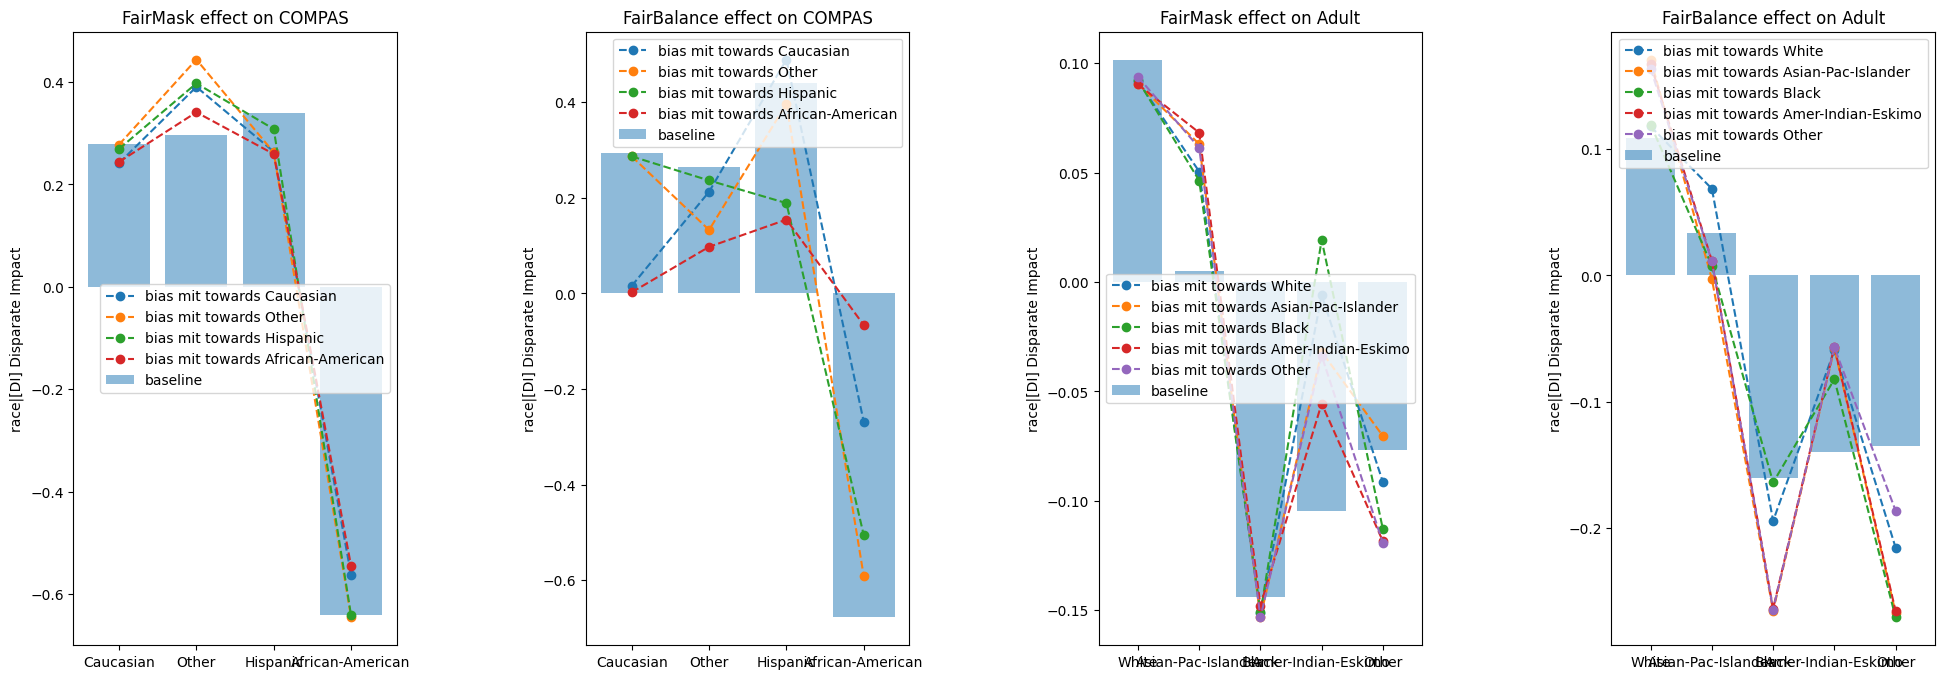

In [9]:
reps = 1
metric =  'race|'+Metrics.DI
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
Caucasian  pos: 835  neg: 602
race: Caucasian  pos: 280  neg: 183
race: Other  pos: 47  neg: 16
race: Hispanic  pos: 102  neg: 39
race: African-American  pos: 399  neg: 360
--------------
Caucasian  pos: 814  neg: 623
race: Caucasian  pos: 294  neg: 169
race: Other  pos: 46  neg: 17
race: Hispanic  pos: 99  neg: 42
race: African-American  pos: 369  neg: 390
--------------
Other  pos: 839  neg: 598
race: Caucasian  pos: 308  neg: 155
race: Other  pos: 43  neg: 20
race: Hispanic  pos: 99  neg: 42
race: African-American  pos: 382  neg: 377
--------------
Hispanic  pos: 825  neg: 612
race: Caucasian  pos: 296  neg: 167
race: Other  pos: 44  neg: 19
race: Hispanic  pos: 98  neg: 43
race: African-American  pos: 380  neg: 379
--------------
African-American  pos: 836  neg: 601
race: Caucasian  pos: 294  neg: 169
race: Other  pos: 47  neg: 16
race: Hispanic  pos: 97  neg: 44
race: African-American  pos: 392  neg: 367

 new tester --

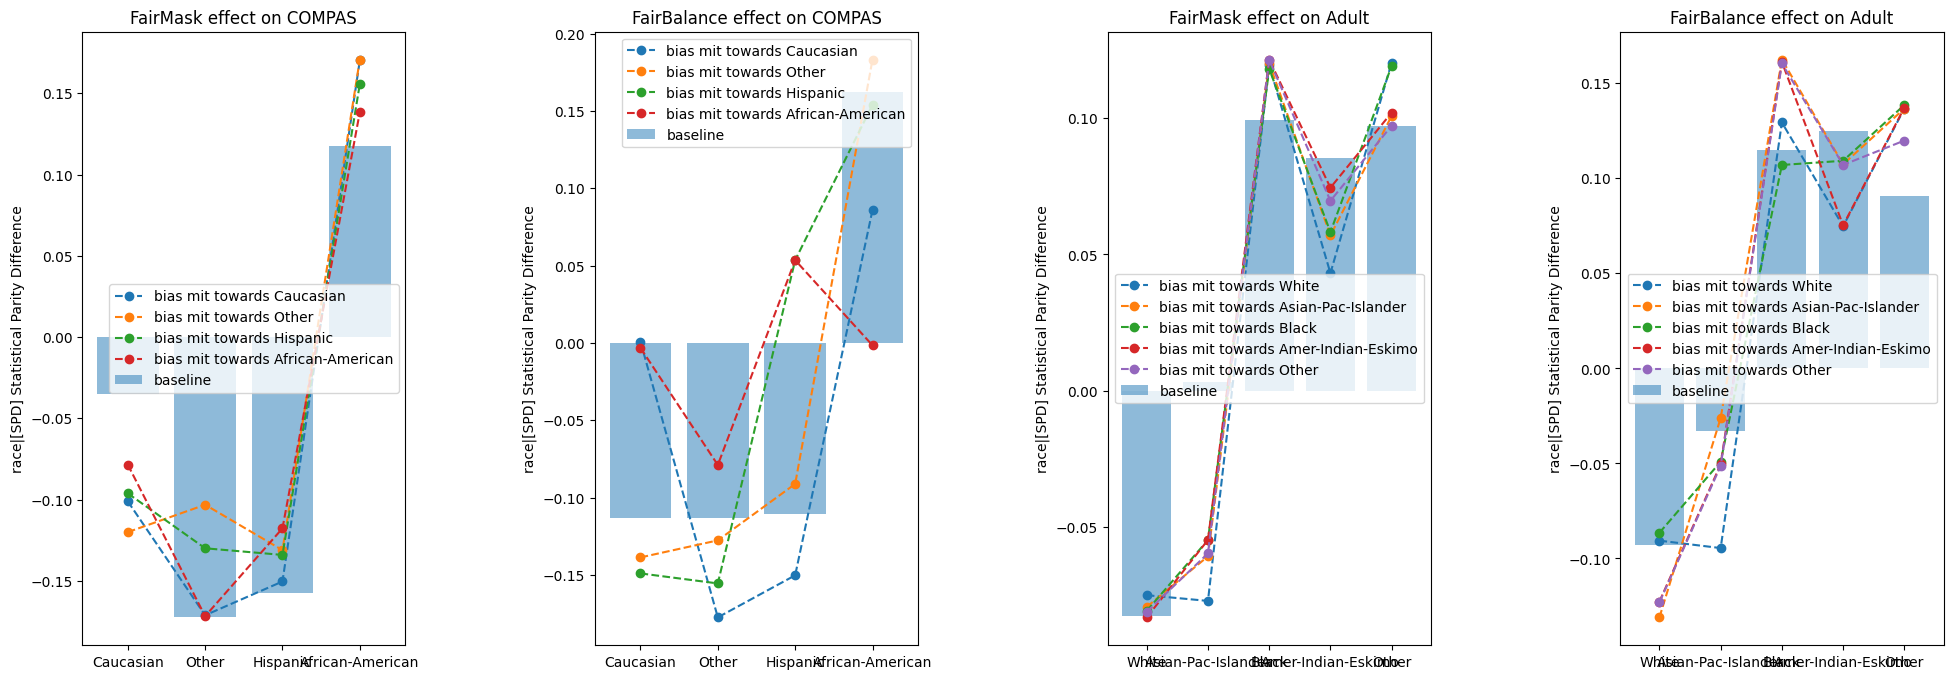

In [10]:
reps = 1
metric =  'race|'+Metrics.SPD
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
Caucasian  pos: 864  neg: 573
race: Caucasian  pos: 328  neg: 142
race: Other  pos: 60  neg: 18
race: Hispanic  pos: 92  neg: 44
race: African-American  pos: 373  neg: 364
Caucasian  pos: 844  neg: 593
race: Caucasian  pos: 342  neg: 144
race: Other  pos: 53  neg: 22
race: Hispanic  pos: 97  neg: 30
race: African-American  pos: 345  neg: 394
Caucasian  pos: 852  neg: 585
race: Caucasian  pos: 358  neg: 150
race: Other  pos: 50  neg: 21
race: Hispanic  pos: 86  neg: 35
race: African-American  pos: 350  neg: 375
Caucasian  pos: 894  neg: 543
race: Caucasian  pos: 342  neg: 146
race: Other  pos: 53  neg: 21
race: Hispanic  pos: 91  neg: 28
race: African-American  pos: 401  neg: 346
Caucasian  pos: 859  neg: 578
race: Caucasian  pos: 325  neg: 165
race: Other  pos: 62  neg: 18
race: Hispanic  pos: 91  neg: 36
race: African-American  pos: 376  neg: 357
Caucasian  pos: 881  neg: 556
race: Caucasian  pos: 359  neg: 143
race: Other 

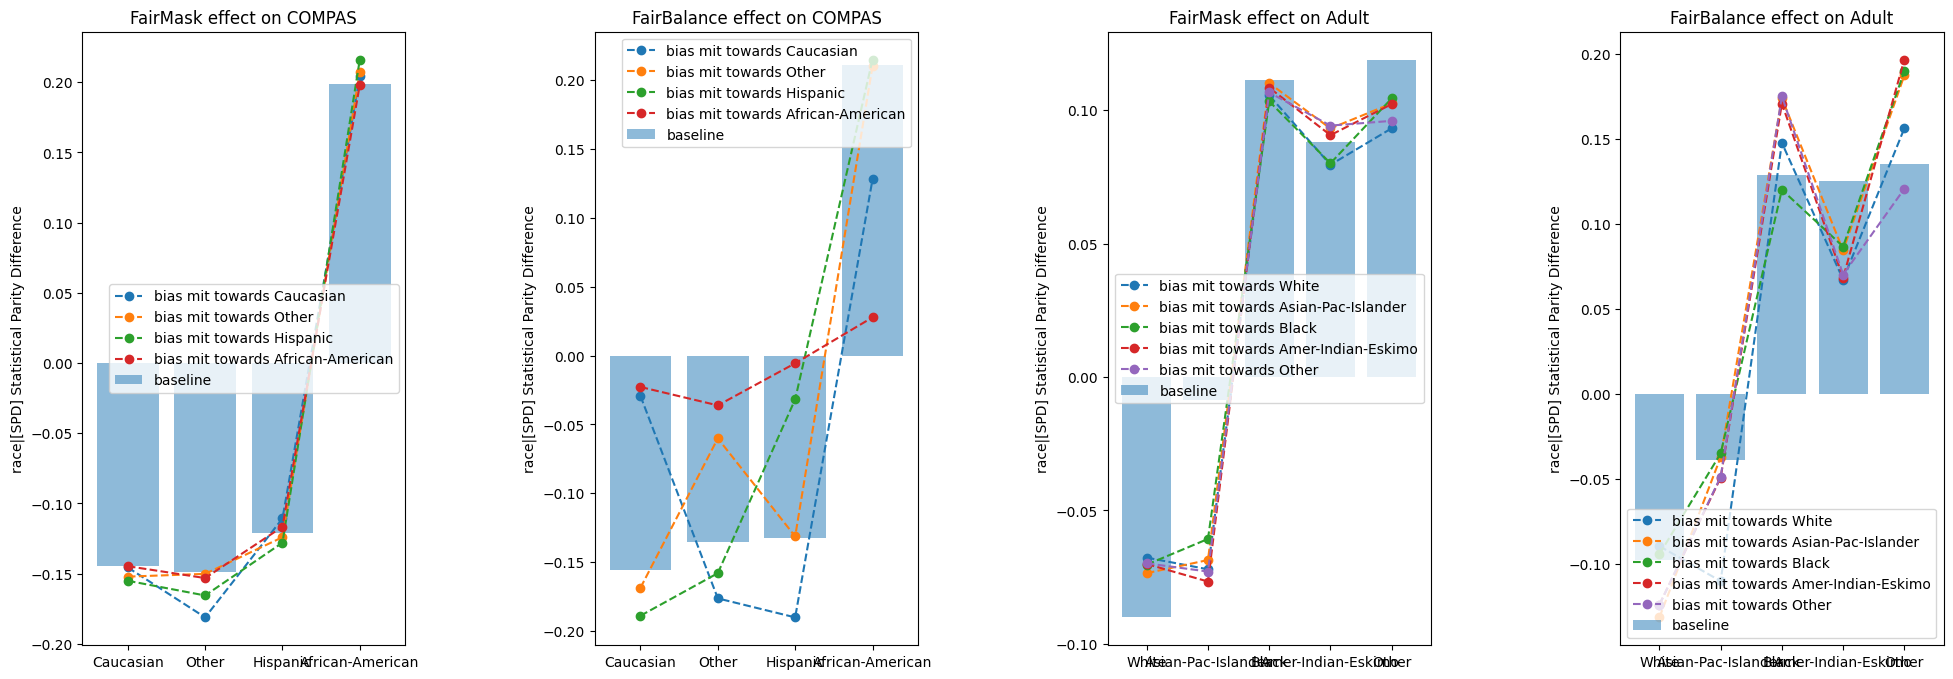

In [11]:
reps = 20
metric =  'race|'+Metrics.SPD
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
Caucasian  pos: 842  neg: 595
race: Caucasian  pos: 346  neg: 152
race: Other  pos: 59  neg: 17
race: Hispanic  pos: 73  neg: 32
race: African-American  pos: 357  neg: 391
Caucasian  pos: 879  neg: 558
race: Caucasian  pos: 367  neg: 155
race: Other  pos: 60  neg: 18
race: Hispanic  pos: 79  neg: 36
race: African-American  pos: 363  neg: 347
Caucasian  pos: 879  neg: 558
race: Caucasian  pos: 364  neg: 136
race: Other  pos: 55  neg: 19
race: Hispanic  pos: 92  neg: 31
race: African-American  pos: 357  neg: 368
Caucasian  pos: 876  neg: 561
race: Caucasian  pos: 330  neg: 148
race: Other  pos: 60  neg: 23
race: Hispanic  pos: 97  neg: 39
race: African-American  pos: 383  neg: 348
Caucasian  pos: 878  neg: 559
race: Caucasian  pos: 342  neg: 141
race: Other  pos: 53  neg: 18
race: Hispanic  pos: 90  neg: 33
race: African-American  pos: 387  neg: 364
--------------
Caucasian  pos: 865  neg: 572
race: Caucasian  pos: 345  neg: 1

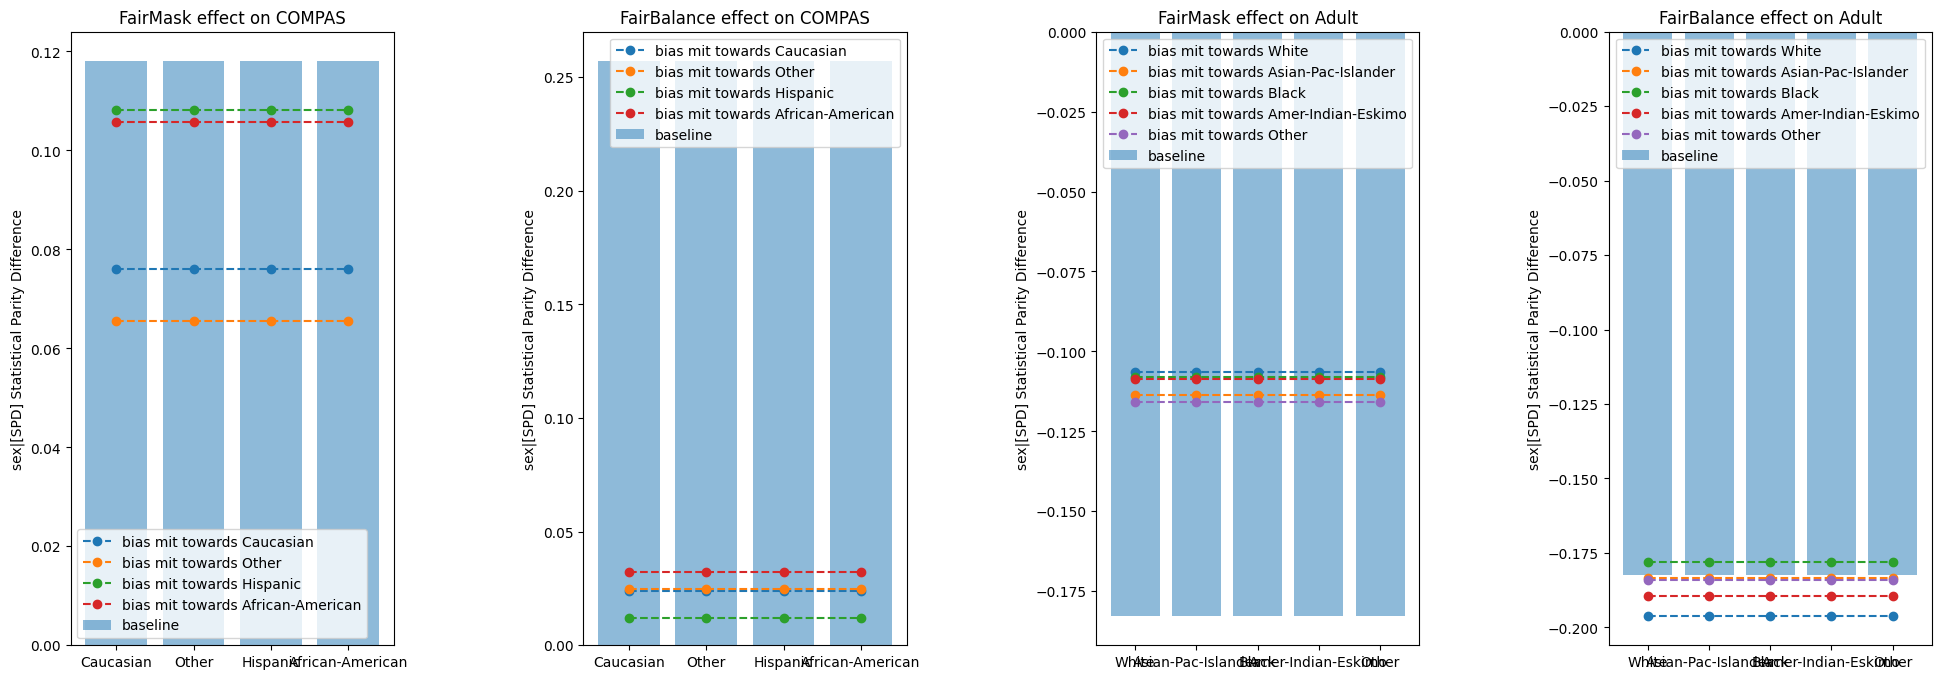

In [12]:
reps = 5
metric =  'sex|'+Metrics.SPD
run_experiment_group(reps, metric)

In [13]:
"""
OBSERVATIONS:

Fairmask does not do much on Compas (presumanbly cause data is so biased)
And does maybe a bit on Adult

Fairbalance just basically tweeks the treshold of positive vs negative outcomes. But just as before groups are discriminated at similar proportions


A different ML method does not really do much to change this as the logib behind this remains the same.
Mayhaps it changes how much the undersampled grops are discriminated against but thats it. 

In every single one of the cases there are subgroups for whom discrimination is iincreased in every example!

TODO:
see what if we ignore gender vs dont
combine some tiny groups into Other
what metric works the best on disproportionate groups
"""

'\nOBSERVATIONS:\n\nFairmask does not do much on Compas (presumanbly cause data is so biased)\nAnd does maybe a bit on Adult\n\nFairbalance just basically tweeks the treshold of positive vs negative outcomes. But just as before groups are discriminated at similar proportions\n\n\nA different ML method does not really do much to change this as the logib behind this remains the same.\nMayhaps it changes how much the undersampled grops are discriminated against but thats it. \n\nIn every single one of the cases there are subgroups for whom discrimination is iincreased in every example!\n\nTODO:\nsee what if we ignore gender vs dont\ncombine some tiny groups into Other\nwhat metric works the best on disproportionate groups\n'